In [1]:
import pandas as pd

In [2]:
# Importando base e retirando colunas desnecessárias 
business_json_path = 'data/yelp_academic_dataset_business.json'
data_business = pd.read_json(business_json_path, lines=True)
drop_columns = ['name', 'address', 'postal_code', 'latitude', 'longitude', 'review_count', 'attributes', 'hours']
data_business = data_business.drop(drop_columns, axis=1)

# Filtrando apenas business da Pensilvânia (PA)
final_business = data_business[data_business['state'] == 'PA']
final_business

,business_id,city,state,stars,is_open,categories
11,7Dv4_HAxsxvadEsT5fxQBg,Pittsburgh,PA,5.0,1,"Automotive, Auto Repair"
39,_4Oe9V-qTpU5iemM9bphlA,Pittsburgh,PA,3.5,1,"Oil Change Stations, Auto Repair, Automotive, ..."
63,ZkzutF0P_u0C0yTulwaHkA,Plum,PA,4.0,1,"Restaurants, Pizza"
69,UyZqOcWxShRRtACCkZFkpQ,Pittsburgh,PA,5.0,1,"Pet Sitting, Pets, Pet Stores, Pet Services, P..."
129,OGVHlFHSXjHuioOvm1wVqg,Avalon,PA,4.0,1,"Dive Bars, Restaurants, Comfort Food, Bars, Ni..."
...,...,...,...,...,...,...
209270,5DpltRkGtV8AnYOlIAt-qA,Pittsburgh,PA,5.0,1,"Shopping, Tobacco Shops"
209277,qWcaGio9JsqrvgmQiIRtIQ,Bridgeville,PA,4.0,1,"Food, Restaurants, Bakeries, Pizza, Sandwiches"
209291,qhmJE8vAy2PvZ-uZS7kifA,McMurray,PA,2.5,1,"Smog Check Stations, Oil Change Stations, Auto..."
209301,NeM7anGnTOTn7sEJavS3sw,Bridgeville,PA,4.5,1,"Food, Coffee & Tea"


In [3]:
size = 1000000
review_json_path = 'data/yelp_academic_dataset_review.json'
review = pd.read_json(review_json_path, lines=True, chunksize=size)

# Merge da base de dados de review com a base de dados de business já filtrada
chunk_list = []
for chunk_review in review:
    chunk_review = chunk_review.drop(['review_id', 'user_id','useful','funny','cool'], axis=1).rename(columns={'stars': 'review_stars'})
    chunk_merged = pd.merge(final_business, chunk_review, on='business_id', how='inner')
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    chunk_list.append(chunk_merged)
    
final_df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
print(final_df)


48074 out of 1,000,000 related reviews
46633 out of 1,000,000 related reviews
45475 out of 1,000,000 related reviews
42876 out of 1,000,000 related reviews
44854 out of 1,000,000 related reviews
39960 out of 1,000,000 related reviews
41530 out of 1,000,000 related reviews
42503 out of 1,000,000 related reviews
900 out of 1,000,000 related reviews
                   business_id           city state  stars  is_open  \
0       7Dv4_HAxsxvadEsT5fxQBg     Pittsburgh    PA    5.0        1   
1       7Dv4_HAxsxvadEsT5fxQBg     Pittsburgh    PA    5.0        1   
2       7Dv4_HAxsxvadEsT5fxQBg     Pittsburgh    PA    5.0        1   
3       7Dv4_HAxsxvadEsT5fxQBg     Pittsburgh    PA    5.0        1   
4       7Dv4_HAxsxvadEsT5fxQBg     Pittsburgh    PA    5.0        1   
...                        ...            ...   ...    ...      ...   
352800  OIEtivFhyEk42uPbis4LjQ     Pittsburgh    PA    3.5        1   
352801  5DpltRkGtV8AnYOlIAt-qA     Pittsburgh    PA    5.0        1   
352802  NeM7

In [4]:
number_of_reviews = 1500
df_count = final_df.groupby(['business_id']).count()
df_count = df_count[df_count['text']>=number_of_reviews].sort_values(by=['text'], ascending=False)
print(df_count)
top_reviews = df_count.index.values
final_df = final_df[final_df['business_id'].isin(top_reviews)]


                        city  state  stars  is_open  categories  review_stars  \
business_id                                                                     
JLbgvGM4FXh9zNP4O5ZWjQ  2073   2073   2073     2073        2073          2073   
u4sTiCzVeIHZY8OlaL346Q  2003   2003   2003     2003        2003          2003   
woXlprCuowrLJswWere3TQ  1501   1501   1501     1501        1501          1501   

                        text  date  
business_id                         
JLbgvGM4FXh9zNP4O5ZWjQ  2073  2073  
u4sTiCzVeIHZY8OlaL346Q  2003  2003  
woXlprCuowrLJswWere3TQ  1501  1501  


**Análise da base**

                   business_id        city state  stars  is_open  \
26404   woXlprCuowrLJswWere3TQ  Pittsburgh    PA    4.5        1   
26405   woXlprCuowrLJswWere3TQ  Pittsburgh    PA    4.5        1   
26406   woXlprCuowrLJswWere3TQ  Pittsburgh    PA    4.5        1   
26407   woXlprCuowrLJswWere3TQ  Pittsburgh    PA    4.5        1   
26408   woXlprCuowrLJswWere3TQ  Pittsburgh    PA    4.5        1   
...                        ...         ...   ...    ...      ...   
211973  JLbgvGM4FXh9zNP4O5ZWjQ  Pittsburgh    PA    4.0        1   
211974  JLbgvGM4FXh9zNP4O5ZWjQ  Pittsburgh    PA    4.0        1   
211975  JLbgvGM4FXh9zNP4O5ZWjQ  Pittsburgh    PA    4.0        1   
211976  JLbgvGM4FXh9zNP4O5ZWjQ  Pittsburgh    PA    4.0        1   
211977  JLbgvGM4FXh9zNP4O5ZWjQ  Pittsburgh    PA    4.0        1   

                                               categories  review_stars  \
26404                American (New), Mexican, Restaurants             2   
26405                American (Ne

(-1.1313670359108041,
 1.1145128279458119,
 -1.1130206965078095,
 1.1006200331670386)

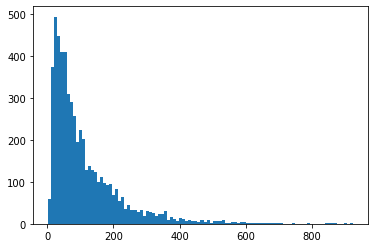

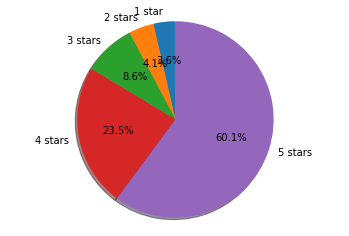

In [5]:
import matplotlib.pyplot as plt

def word_count(x):
    return len(x.split())

final_df['words_count'] = final_df['text'].apply(word_count)
print(final_df)
print('Descrição estatística da quantidade de palavras dos reviews:\n\n', final_df['words_count'].describe())

plt.hist(final_df['words_count'], bins=100, label='Quantidade de palavras')

    
reviews_1 = final_df[final_df['review_stars'] <= 1]
reviews_2 = final_df[(final_df['review_stars'] <= 2) & (final_df['review_stars'] > 1)]
reviews_3 = final_df[(final_df['review_stars'] <= 3) & (final_df['review_stars'] > 2)]
reviews_4 = final_df[(final_df['review_stars'] <= 4) & (final_df['review_stars'] > 3)]
reviews_5 = final_df[(final_df['review_stars'] <= 5) & (final_df['review_stars'] > 4)]

labels = '1 star', '2 stars', '3 stars', '4 stars', '5 stars'
sizes = [len(reviews_1), len(reviews_2), len(reviews_3), len(reviews_4), len(reviews_5)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

**Reviews Negativos**

In [15]:
n_components = 5
max_df = 0.85
min_df=2

for business in top_reviews:
    business_reviews = final_df[(final_df['business_id'] == business) & (final_df['review_stars'] <= 2)]['text']
    print('\n*****', business, '*****\n')
    print(data_business[data_business['business_id'] == business], ' \n')
    print('Dataset size:', len(business_reviews))
    
    vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words='english')
    
    
    vectors = vectorizer.fit_transform(business_reviews) 
    words = np.array(vectorizer.get_feature_names())
    print('words', len(words), vectors.shape, '\n')

    nmf = NMF(n_components=n_components, solver="mu")
    
    W = nmf.fit_transform(vectors)
    H = nmf.components_

    for i, topic in enumerate(H):
         print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-5:]]])))


***** JLbgvGM4FXh9zNP4O5ZWjQ *****

                   business_id        city state  stars  is_open  \
120818  JLbgvGM4FXh9zNP4O5ZWjQ  Pittsburgh    PA    4.0        1   

                                               categories  
120818  Specialty Food, Meat Shops, Steakhouses, Food,...    

Dataset size: 212
words 1373 (212, 1373) 

Topic 1: just,food,place,potatoes,meat
Topic 2: bar,said,table,hostess,minutes
Topic 3: service,food,brunch,drinks,bar
Topic 4: fried,brunch,waffle,waffles,chicken
Topic 5: horrible,marrow,bone,cold,steak

***** u4sTiCzVeIHZY8OlaL346Q *****

                  business_id        city state  stars  is_open  \
75057  u4sTiCzVeIHZY8OlaL346Q  Pittsburgh    PA    4.5        1   

                                              categories  
75057  Seafood, Latin American, Argentine, Restaurant...    

Dataset size: 98
words 746 (98, 746) 

Topic 1: good,don,place,food,steak
Topic 2: wait,time,people,restaurant,line
Topic 3: tip,dollars,couple,group,did
Topic 4:

**Reviews Positivos**

In [13]:
n_components = 5
max_df = 0.85
min_df=2

for business in top_reviews:
    business_reviews = final_df[(final_df['business_id'] == business) & (final_df['review_stars'] > 4)]['text']
    print('\n*****', business, '*****\n')
    print(data_business[data_business['business_id'] == business], ' \n')
    print('Dataset size:', len(business_reviews))
    
    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
    
    
    vectors = vectorizer.fit_transform(business_reviews) 
    words = np.array(vectorizer.get_feature_names())
    print('words', len(words), vectors.shape, '\n')

    nmf = NMF(n_components=n_components, solver="mu")
    
    W = nmf.fit_transform(vectors)
    H = nmf.components_

    for i, topic in enumerate(H):
         print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-5:]]])))
    


***** JLbgvGM4FXh9zNP4O5ZWjQ *****

                   business_id        city state  stars  is_open  \
120818  JLbgvGM4FXh9zNP4O5ZWjQ  Pittsburgh    PA    4.0        1   

                                               categories  
120818  Specialty Food, Meat Shops, Steakhouses, Food,...    

Dataset size: 988
words 2984 (988, 2984) 

Topic 1: place,meat,got,delicious,good
Topic 2: best,bar,brunch,mary,bloody
Topic 3: drinks,service,atmosphere,food,great
Topic 4: amazing,steak,ribeye,marrow,bone
Topic 5: cocktails,love,ve,chicken,best

***** u4sTiCzVeIHZY8OlaL346Q *****

                  business_id        city state  stars  is_open  \
75057  u4sTiCzVeIHZY8OlaL346Q  Pittsburgh    PA    4.5        1   

                                              categories  
75057  Seafood, Latin American, Argentine, Restaurant...    

Dataset size: 1497
words 3189 (1497, 3189) 

Topic 1: got,delicious,good,steak,sandwich
Topic 2: food,long,worth,line,wait
Topic 3: place,staff,service,food,great
